#Instalments

In [ ]:
!pip install pyod 

In [ ]:
!pip install git+https://github.com/MaxHalford/prince.git

  Cloning https://github.com/MaxHalford/prince.git to /tmp/pip-req-build-aah83w8c
  Running command git clone -q https://github.com/MaxHalford/prince.git /tmp/pip-req-build-aah83w8c


In [ ]:
# !pip install hdbscan

In [ ]:
# !pip install shap

# Imports

In [ ]:
from os import path, system
import numpy as np
import pandas as pd

import random
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd


# Scipy
import scipy
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra


# sklearn
from sklearn import preprocessing
from sklearn import metrics

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.feature_selection import f_classif
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import radius_neighbors_graph

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder


# PyOD
from pyod.models.copod import COPOD
from pyod.models.hbos import HBOS
from pyod.models.sos import SOS
from pyod.models.abod import ABOD
from pyod.models.lmdd import LMDD
from pyod.models.ocsvm import OCSVM
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.cof import COF
from pyod.models.pca import PCA as PCAod
from pyod.models.knn import KNN


# matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import matplotlib.cm as cm
%matplotlib inline

# Timing
from timeit import default_timer as timer

# HDBSCAN
# from hdbscan import HDBSCAN

# Functions

In [ ]:
def load_dataset(dataset_path, one_in_every, sample=False):

    if not path.exists(dataset_path):
        system('cat data/USCensus1990.data.txt.* > data/USCensus1990.data.txt')

    if sample:
      a_dataframe = pd.read_csv(dataset_path, header=0, skiprows=lambda i: i % one_in_every != 0)
    else:
      a_dataframe = pd.read_csv(dataset_path)


    # need to ignore caseid
    a_dataframe = a_dataframe.drop(columns=['caseid'])

    return a_dataframe

In [ ]:
def OutlierFilter(X_train, alg=0, outlier_frac=0.1):
  
    # Proximity-Based - Connectivity-Based Outlier Factor
    if alg == 0 or alg == 'pca' or alg == 'PCA':
        clf = PCAod()

    # Linear Model - One-Class Support Vector Machines
    elif alg == 1 or alg == 'knn' or alg == 'KNN':
        clf = KNN(contamination=0.1, n_neighbors=5, method='median', radius=1.0,
                  algorithm='auto', leaf_size=30, metric='minkowski', p=2, 
                  metric_params=None, n_jobs=1)

    # AutoEncoder
    elif alg == 2 or alg == 'auto_encoder' or alg == 'AutoEncoder':
        clf = AutoEncoder(epochs=100, batch_size=32, dropout_rate=0.2, 
                          l2_regularizer=0.1, validation_size=0.1, 
                          preprocessing=True, verbose=1, random_state=None, 
                          contamination=outlier_frac)

    # Neural Network - Deep One-Class Classification
    elif alg == 3 or alg == 'DeepSVDD':
        clf = DeepSVDD(c=None, use_ae=True, hidden_neurons=None, 
                       hidden_activation='relu', output_activation='sigmoid', 
                       optimizer='adam', epochs=30, batch_size=32, 
                       dropout_rate=0.2, l2_regularizer=0.1, 
                       validation_size=0.1, preprocessing=True, verbose=1, 
                       random_state=None, contamination=outlier_frac)

    else:
        print("Unknown outliers screening algorithm")

    X_train = X_train.astype(float)
    clf.fit(X_train)

    # y_pred = clf.predict(X_train[feat_cols].values)  # predict outliers
    # outlier_index = np.where(y_pred == 1)

    return clf  # outlier_index[0]

In [ ]:
def Clustering(X, alg=0, n_clusters=10):
  
    # K-means  - To Do: try to import and use fuzzy kmean
    if alg == 0 or alg == 'kmeans' or alg == 'KMEANS':
        clusterer = KMeans(n_clusters=n_clusters)

    # AgglomerativeClustering
    elif alg == 1 or alg == 'agg' or alg == 'AgglomerativeClustering':
        clusterer = AgglomerativeClustering(n_clusters=n_clusters)

    # DBSCAN
    elif alg == 2 or alg == 'dbscan' or alg == 'DBSCAN':
        clusterer = DBSCAN(eps=0.25, min_samples=30)

    # # HDBSCAN - To Do: import and use hdbscan
    # elif alg == 3 or alg == 'hdbscan' or alg == 'HDBSCAN':
    #     clusterer = HDBSCAN(cluster_selection_epsilon=0.2, min_cluster_size=200, 
    #                         min_samples=30, n_clusters=n_clusters)
    
    else:
        print("Unknown algorithm")

    result = clusterer.fit(X)
    return result


1.   chose number of clusters by loss from kmeans

2.   noam 




In [ ]:
def DimensionReduction(X, alg=0, neighbors_num=10, n_components = 2):
  
    # PCA
    if alg == 0 or alg == 'pca' or alg == 'PCA':
        dim_reductor = PCA(n_components=n_components)

    # MDS
    elif alg == 1 or alg == 'mds' or alg == 'MDS':
        dim_reductor = MDS(n_components = n_components, max_iter=100, n_init=1)

    # LLE - LocallyLinearEmbedding
    elif alg == 2 or alg == 'lle' or alg == 'LLE':
        dim_reductor = LocallyLinearEmbedding(n_neighbors=neighbors_num, 
                                              n_components=n_components, 
                                              eigen_solver='auto', 
                                              method='standard')

    # LEM (Laplacian Eigenmaps)
    elif alg == 3 or alg == 'lem' or alg == 'LEM':
        dim_reductor = SpectralEmbedding(n_neighbors=neighbors_num, 
                                         n_components=n_components)
        
    # Isomap
    elif alg == 5 or alg == 'isomap' or alg == 'ISOMAP':
        dim_reductor = Isomap(n_neighbors=neighbors_num, n_components=n_components)

    # ICA
    elif alg == 6 or alg == 'ica' or alg == 'ICA':
        dim_reductor = FastICA(n_components = n_components)

    # t-SNE
    elif alg == 7 or alg == 'tsne' or alg == 'TSNE':
        dim_reductor = TSNE(n_components = n_components)
    
    else:
        print("Unknown algorithm")

    return dim_reductor.fit_transform(X)

In [ ]:
# https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c

# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silhouette(model, df, **kwargs):
    features, y = sep_features_y(df)
    _, y_pred = fit_model(model=model, data=features, **kwargs)
    print(silhouette_score(features, y))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    silhouette_avg = silhouette_score(features, y_pred)
    print(
            "For n_clusters =",
            10,
            "The average silhouette_score is :",
            silhouette_avg,
        )
    y_lower = 10
    sample_silhouette_values = silhouette_samples(features, y_pred)
    for i in range(10):
        ith_cluster_silhouette_values = sample_silhouette_values[y_pred == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / 10)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    ax1.set_yticks([])
    ax1.set_xticks([-0.4,-0.2,-0, 0.2, 0.4, 0.6, 0.8, 1])
    
    return silhouette_avg

In [ ]:
def run_experiment(X_train, y_train, n_experiments, sample_frac,
                   AD_model, outlier_frac, Cluster_models, n_clusters):
    print("Preprocessing starts")
    start = timer()
    mi_scores = {}
    silhouette_scores = {}
    for Cluster_model in Cluster_models:
      mi_scores[Cluster_model] = {}
      silhouette_scores[Cluster_model] = []
      for variable in label_col:
        mi_scores[Cluster_model][variable] = []
  
    # Filter Outliers
    outlier_filter = OutlierFilter(X_train, alg=AD_model, outlier_frac=outlier_frac)
    train_anom_pred = outlier_filter.predict(X_train.values)  # predict outliers
    train_outlier_index = np.where(train_anom_pred == 1)[0]

    filtered_data = X_train.drop(train_outlier_index)
    filtered_labels = y_train.drop(train_outlier_index) # .to_numpy(), To do - Check!!!!!
    # outlier_data = X_train.iloc[outlier_indexes]
    # outlier_labels = y_train[y_cols].iloc[outlier_indexes]

    filtered_data = X_train
    filtered_labels = y_train
    
    end = timer()
    print("Finished preprocessing, preprocessing time was " + str(end - start) + " seconds\n")
    
    for exp in range(n_experiments):
        start = timer()
        print("starting experiment number " + str(exp))
        
        # Use train_test_split to split x and y correspondingly
        _, X_sample, _, y_sample = train_test_split(filtered_data, filtered_labels, 
                                                    test_size=sample_frac)
        X_sample.reset_index(drop=True, inplace=True)
        y_sample.reset_index(drop=True, inplace=True)
        
        # Cluster methods
        for Cluster_model in Cluster_models:
          clusterer = Clustering(X_sample, alg=Cluster_model, 
                                 n_clusters=n_clusters)
          clusters_labels = clusterer.labels_

          # mutual_info_score
          for variable in label_col:
            # Mutual information
            mi_variable = normalized_mutual_info_score(y_sample[variable].to_numpy(), clusters_labels)
            mi_scores[Cluster_model][variable].append(mi_variable)
            
          # Silhouette
          silhouette_avg = silhouette_score(X_sample, clusters_labels)
          silhouette_scores[Cluster_model].append(silhouette_avg)
        
        end = timer()
        print("Finished experiment number " + str(exp) + ", time was " + str(end - start) + " seconds\n")


    return mi_scores, silhouette_scores

In [ ]:
def run_experiment_clustering(X_train, y_train, AD_model, outlier_frac, Cluster_model, n_clusters):
    print("Preprocessing starts")
    start = timer()
  
    # Filter Outliers
    outlier_filter = OutlierFilter(X_train, alg=AD_model, outlier_frac=outlier_frac)
    train_anom_pred = outlier_filter.predict(X_train.values)
    train_outlier_index = np.where(train_anom_pred == 1)[0]

    filtered_data = X_train.drop(train_outlier_index)
    filtered_labels = y_train.drop(train_outlier_index)

    end = timer()
    print("Finished preprocessing, preprocessing time was " + str(end - start) + " seconds\n")
    
    start = timer()
    print("starting experiment")
    
    # Cluster methods
    clusterer = Clustering(X_train, alg=Cluster_model, 
                            n_clusters=n_clusters)
    clusters_labels = clusterer.labels_
  
    end = timer()
    print("Finished experiment, time was " + str(end - start) + " seconds\n")


    return clusters_labels

In [ ]:
def find_elbow(X_train, range_clusters):
  Sum_of_squared_distances = []
  for clusters_size in range_clusters:
    start = timer()

    km = KMeans(n_clusters=clusters_size)
    km = km.fit(X_train)
    Sum_of_squared_distances.append(km.inertia_)

    end = timer()
    print("Finished clustering number " + str(clusters_size) + ", time was " + str(end - start) + " seconds\n")
    print("loss = " + str(km.inertia_))
  print(Sum_of_squared_distances)
  return Sum_of_squared_distances

In [ ]:
# from jqmcvi import base
 
# clus0 = prediction.loc[prediction.Species == 0]
# clus1 = prediction.loc[prediction.Species == 1]
# clus2 = prediction.loc[prediction.Species == 2]
# cluster_list = [clus0.values, clus1.values, clus2.values]
 
# print(base.dunn(cluster_list))

#Main

In [ ]:
!git clone https://github.com/Eyalcohenx/UnsupervisedLearningProject
%cd /content/UnsupervisedLearningProject

Cloning into 'UnsupervisedLearningProject'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 21 (delta 6), reused 17 (delta 4), pack-reused 0
Unpacking objects: 100% (21/21), done.
Checking out files: 100% (10/10), done.
/content/UnsupervisedLearningProject


##Load data

In [ ]:
# Loading the data
data = load_dataset('data/USCensus1990.data.txt', one_in_every=10, sample=True)

In [ ]:
len(data)
# data[:5]

245828

In [ ]:
y_cols = ['dAge'] #, 'dHispanic', 'iYearwrk', 'iSex'] # for now let's assume it's only one label
label_col = ['dAge', 'dHispanic', 'iYearwrk', 'iSex']
all_col = data.columns.values.tolist()
feat_cols = list(set(all_col) - set(label_col))
# categorial_col = []

In [ ]:
bin_col = data.columns[data.isin([0,1]).all()]
bin_feat_col = list(set(bin_col) - set(label_col))
non_bin_feat_col = list(set(feat_cols) - set(bin_feat_col))

print(bin_feat_col)
print(len(bin_feat_col))

['iRownchld', 'iKorean', 'iRrelchld', 'dIncome5', 'dIncome8', 'iSept80', 'iMay75880', 'dIncome7', 'iOthrserv', 'dIncome3', 'dIncome6', 'dIncome4', 'iFeb55', 'iVietnam', 'iWWII', 'dIncome2']
16


## One-hot encoding

In [ ]:
enc_X = OneHotEncoder(sparse=False, handle_unknown='ignore')

one_hot_data_X = enc_X.fit_transform(data)

# one_hot_data_X = pd.DataFrame(enc_X.fit_transform(data[non_bin_feat_col]))
# one_hot_data_X.columns = enc_X.get_feature_names(non_bin_feat_col)

# one_hot_data_X = pd.concat([one_hot_data_X, data[bin_feat_col]], axis=1)

In [ ]:
# one_hot_feat_cols = one_hot_data_X.columns.values.tolist()

## Train/Test split

In [ ]:
# Split to train test
X_train = one_hot_data_X
y_train = data[label_col]

In [ ]:
# print(one_hot_feat_cols)

In [ ]:
# X_train.reset_index(drop=True, inplace=True)
# X_test.reset_index(drop=True, inplace=True)
# y_train.reset_index(drop=True, inplace=True)
# y_test.reset_index(drop=True, inplace=True)

In [ ]:
# outlier_filter_tryout = OutlierFilter(X_train, alg='DeepSVDD', outlier_frac=0.05)

## MCA of discrete features

Some of the data is categorical, so encode to one hot, do an MCA (which is a PCA to one hot) and then run all the methods into a cluster, and so on. Record in the file whether we treated the data as categorical or not.

Run MCA on the discrete variables and PCA on the continuous variables and then connect everything.

In [ ]:
# https://github.com/MaxHalford/prince
from prince import MCA

In [ ]:
len(X_train)

245828

In [ ]:
mca = MCA(
    n_components=50,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)

mca_transformed_train_data = mca.fit_transform(X_train)

In [ ]:
# mca_transformed_test_data = mca.transform(X_test)

In [ ]:
# mca.column_contributions

In [ ]:
# type(mca_transformed_train_data)
# print(mca_transformed_train_data.columns.values.tolist())

## Evaluation Methods

**Mutual Information Score:**

If you know about a true division of data into labels, (not all external variables are like that) then the mutual information between the clusters that came out and the tagging of the points (according to the external variable) can be a measure of how close they are (the higher the mutual information then the labels increased our certainty and confirm the division into clusters).

In [ ]:
K = range(1, 50, 2)

Sum_of_squared_distances = find_elbow(mca_transformed_train_data, K)

Finished clustering number 1, time was 1.2773674920000246 seconds

loss = 86140.31614209361
Finished clustering number 3, time was 4.604671637999985 seconds

loss = 53563.15632755902
Finished clustering number 5, time was 8.579867102000009 seconds

loss = 46239.542263717245
Finished clustering number 7, time was 10.152779691000006 seconds

loss = 41616.96109081922
Finished clustering number 9, time was 14.495758510999991 seconds

loss = 37324.359307004095
Finished clustering number 11, time was 13.372278741999992 seconds

loss = 33612.91045970958
Finished clustering number 13, time was 8.831988318000015 seconds

loss = 30804.020751752927
Finished clustering number 15, time was 10.48460609 seconds

loss = 28812.649839330585
Finished clustering number 17, time was 11.87349905100001 seconds

loss = 25605.962906535657
Finished clustering number 19, time was 11.690081875999965 seconds

loss = 24223.62861249029
Finished clustering number 21, time was 13.099463509000032 seconds

loss = 22678.

In [ ]:
print(K)
print(Sum_of_squared_distances)

range(1, 50, 2)
[86140.31614209361, 53563.15632755902, 46239.542263717245, 41616.96109081922, 37324.359307004095, 33612.91045970958, 30804.020751752927, 28812.649839330585, 25605.962906535657, 24223.62861249029, 22678.656881380535, 21102.220184269303, 20139.719518513935, 19404.4652715498, 18705.669318974607, 17683.431192769436, 17425.789097590656, 16705.44082164663, 16273.877637122545, 16011.460722802532, 15590.117724442727, 15234.21838829781, 14922.713721138894, 14590.522325479305, 14325.319552049725]


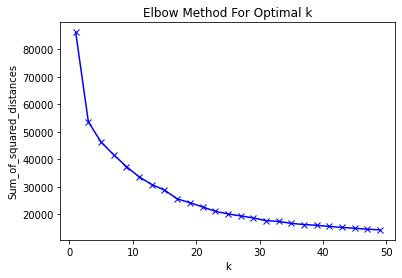

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


range(1, 50)

[122740.76621547985, 102293.11823134363, 90133.40037856312, 86307.3023278607, 82687.3597616891, 80350.33865199535, 77804.63019585537, 75376.88944296763, 73003.69871508545, 71545.33586852971, 70011.29437326014, 67750.1373707972, 66481.60734283783, 65139.859365556214, 63714.17184326097, 62391.451604141934, 61416.41302261276, 58596.63701268889, 58102.56772599531, 56717.84591564287, 55745.44782995724, 53487.554944765056, 53342.980177335325, 52119.049715925015, 51676.24044096953, 51245.361636461595, 50111.32603487036, 49395.922886777524, 48634.937654507215, 47200.129822896975, 46849.34377430988, 45975.872935541905, 46036.50410565494, 45072.15424226565, 44885.32706663632, 44231.912940732465, 43390.774404801865, 43316.84969261089, 42224.7215407193, 42812.322590323616, 41712.40473889476, 41434.07210500791, 41433.18511647169, 40960.03669766159, 40269.52787166288, 40448.17666071877, 39695.69130657727, 39489.99027424077, 38798.8809667716]

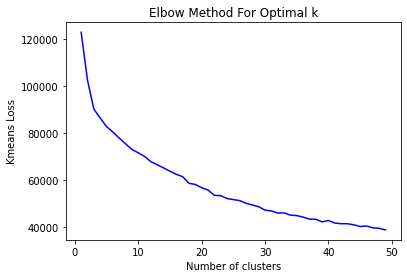

In [ ]:
from matplotlib import pyplot as plt

x = range(1, 50)
y = [122740.76621547985, 102293.11823134363, 90133.40037856312, 86307.3023278607, 82687.3597616891, 80350.33865199535, 77804.63019585537, 75376.88944296763, 73003.69871508545, 71545.33586852971, 70011.29437326014, 67750.1373707972, 66481.60734283783, 65139.859365556214, 63714.17184326097, 62391.451604141934, 61416.41302261276, 58596.63701268889, 58102.56772599531, 56717.84591564287, 55745.44782995724, 53487.554944765056, 53342.980177335325, 52119.049715925015, 51676.24044096953, 51245.361636461595, 50111.32603487036, 49395.922886777524, 48634.937654507215, 47200.129822896975, 46849.34377430988, 45975.872935541905, 46036.50410565494, 45072.15424226565, 44885.32706663632, 44231.912940732465, 43390.774404801865, 43316.84969261089, 42224.7215407193, 42812.322590323616, 41712.40473889476, 41434.07210500791, 41433.18511647169, 40960.03669766159, 40269.52787166288, 40448.17666071877, 39695.69130657727, 39489.99027424077, 38798.8809667716]

plt.plot(x, y, 'b-')
plt.xlabel('Number of clusters')
plt.ylabel('Kmeans Loss')
plt.title('Elbow Method For Optimal k')

plt.savefig("ElbowNumClustes.svg")

silhouette_scores = {2: 0.14913487777814932, 3: 0.157675500599963, 4: 0.17760047701074824, 5: 0.15225717871969127, 6: 0.19233210228593023, 7: 0.1654747561377371, 8: 0.14398700308281834, 9: 0.18512868037298305, 10: 0.1410044813147934}

In [ ]:
# chosen after testing silhouette_scores
num_clusters = 20

In [ ]:
mi_scores1, silhouette_scores1 = run_experiment(mca_transformed_train_data, y_train, 
                                                n_experiments=20, sample_frac=0.1,
                                                AD_model='PCA', outlier_frac=0.01,
                                                Cluster_models=['kmeans', 'agg', 'dbscan'], 
                                                n_clusters=num_clusters)


Preprocessing starts
Finished preprocessing, preprocessing time was 5.451929325000009 seconds

starting experiment number 0
Finished experiment number 0, time was 93.30487956800002 seconds

starting experiment number 1
Finished experiment number 1, time was 85.40031640400002 seconds

starting experiment number 2
Finished experiment number 2, time was 83.81994670800003 seconds

starting experiment number 3
Finished experiment number 3, time was 82.850916487 seconds

starting experiment number 4
Finished experiment number 4, time was 87.825440157 seconds

starting experiment number 5
Finished experiment number 5, time was 84.97330532599995 seconds

starting experiment number 6
Finished experiment number 6, time was 81.91698956300002 seconds

starting experiment number 7
Finished experiment number 7, time was 83.32695351899997 seconds

starting experiment number 8
Finished experiment number 8, time was 82.46977134400004 seconds

starting experiment number 9
Finished experiment number 9, t

In [ ]:
mi_scores_copy = mi_scores1
for alg in ['kmeans', 'agg', 'dbscan']:
  for variable in label_col:
    mi_scores_copy[alg][variable] = np.mean(mi_scores_copy[alg][variable])
mi_scores_copy

{'agg': {'dAge': 0.3291096749257466,
  'dHispanic': 0.0316725468417425,
  'iSex': 0.0636490430921633,
  'iYearwrk': 0.475630840210105},
 'dbscan': {'dAge': 0.27715723961838235,
  'dHispanic': 0.02577478042563398,
  'iSex': 0.058095293497869425,
  'iYearwrk': 0.4054602565941967},
 'kmeans': {'dAge': 0.348480800478615,
  'dHispanic': 0.03390521908752346,
  'iSex': 0.07728865675511133,
  'iYearwrk': 0.49654305058051235}}

In [ ]:
clustering_x, clustering_y = mca_transformed_train_data, y_train

cluster_lables = run_experiment_clustering(clustering_x, clustering_y,
                                            AD_model='PCA', outlier_frac=0.01,
                                            Cluster_model='kmeans', 
                                            n_clusters=num_clusters)

Preprocessing starts
Finished preprocessing, preprocessing time was 5.04919151099989 seconds

starting experiment
Finished experiment, time was 58.8322005980001 seconds



In [ ]:
mi_scores2

{'hdbscan': {'dAge': [0.28718724797027784],
  'dHispanic': [0.015354400161607853],
  'iSex': [0.04742070862679971],
  'iYearwrk': [0.3717815272738042]}}

## Dimention Reduction & Vizualization

In [ ]:
clusters_colors = cm.rainbow(np.linspace(0, 1, num_clusters))

clusters_shapes = ['.', 'v', '2', 's', 'X', 'p', 'P', '*', 'h', '+', 'D', '.', 'v', '2', 's', 'X', 'p', 'P', '*', 'h', '+', 'D', '.', 'v', '2', 's', 'X', 'p', 'P', '*', 'h', '+', 'D',]

In [ ]:
from collections import Counter

clusters_sizes = Counter(cluster_lables)

big_clusters = clusters_sizes.most_common(8)

big_clusters_indexes = [first for first, second in big_clusters]

In [ ]:

# VAR:        TYP:   DES:    LEN:   CAT:    VARIABLE/CATEGORY LABEL:
# __________________________________________________________________________________
# YEARWRK      C       X      1             Yr. Last Worked
#                                   0       N/a Less Than 16 Yrs. Old
#                                   1       1990
#                                   2       1989
#                                   3       1988
#                                   4       1985 to 1987
#                                   5       1980 to 1984
#                                   6       1979 or Earlier
#                                   7       Never Worked

# VAR:        TYP:   DES:    LEN:   CAT:    VARIABLE/CATEGORY LABEL:
# __________________________________________________________________________________
# SEX          C       X      1             Sex
#                                   0       Male
#                                   1       Female

# VAR:        TYP:   DES:    LEN:   CAT:    VARIABLE/CATEGORY LABEL:
# __________________________________________________________________________________
# DAGE      C       X      1             Yr. Last Worked
#                                   0       0 Yrs. Old
#                                   1       <13 Yrs. Old
#                                   2       <20 Yrs. Old
#                                   3       <30 Yrs. Old
#                                   4       <40 Yrs. Old
#                                   5       <50 Yrs. Old
#                                   6       <65 Yrs. Old
#                                   7       else

# VAR:        TYP:   DES:    LEN:   CAT:    VARIABLE/CATEGORY LABEL:
# __________________________________________________________________________________
# HISPANIC     C       X      3             Detailed Hispanic Origin Code See Append
#                                    0     Not Hispanic < 200
#                                    1     Other Hispanic 209
#                                    2     Mexican, Mex Am 220
#                                    3     Other Hispanic 230
#                                    4     Other Hispanic 249
#                                    5     Other Hispanic 250 260
#                                    6     Puerto Rican 261 270
#                                    7     Cuban 271 274
#                                    8     Other Hispanic 289
#                                    9     Other Hispanic 290 401
'N/a Less Than 16 Yrs. Old','1990','1989','1988','1985 to 1987','1980 to 1984','1979 or Earlier','Never Worked'

labels_mapping = {}
labels_mapping['dAge'] = {i:val for i,val in enumerate(['0 Yrs. Old','<13 Yrs. Old','<20 Yrs. Old','<30 Yrs. Old','<40 Yrs. Old','<50 Yrs. Old','<65 Yrs. Old','else'])}
labels_mapping['dHispanic'] = {i:val for i,val in enumerate(['Not Hispanic < 200','Other Hispanic 209','Mexican, Mex Am 220','Other Hispanic 230','Other Hispanic 249','Other Hispanic 250 260','Puerto Rican 261 270','Cuban 271 274','Other Hispanic 289','Other Hispanic 290 401'])}
labels_mapping['iYearwrk'] = {i:val for i,val in enumerate(['N/a Less Than 16 Yrs. Old','1990','1989','1988','1985 to 1987','1980 to 1984','1979 or Earlier','Never Worked'])}
labels_mapping['iSex'] = {i:val for i,val in enumerate(['Male', 'Female'])}
labels_mapping

{'dAge': {0: '0 Yrs. Old',
  1: '<13 Yrs. Old',
  2: '<20 Yrs. Old',
  3: '<30 Yrs. Old',
  4: '<40 Yrs. Old',
  5: '<50 Yrs. Old',
  6: '<65 Yrs. Old',
  7: 'else'},
 'dHispanic': {0: 'Not Hispanic < 200',
  1: 'Other Hispanic 209',
  2: 'Mexican, Mex Am 220',
  3: 'Other Hispanic 230',
  4: 'Other Hispanic 249',
  5: 'Other Hispanic 250 260',
  6: 'Puerto Rican 261 270',
  7: 'Cuban 271 274',
  8: 'Other Hispanic 289',
  9: 'Other Hispanic 290 401'},
 'iSex': {0: 'Male', 1: 'Female'},
 'iYearwrk': {0: 'N/a Less Than 16 Yrs. Old',
  1: '1990',
  2: '1989',
  3: '1988',
  4: '1985 to 1987',
  5: '1980 to 1984',
  6: '1979 or Earlier',
  7: 'Never Worked'}}

In [ ]:
clusters_tags = ['nothing special',
                 'young cluster non hispanic',
                 '1990 year worked',
                 '',
                 '',
                 '',
                 '',
                 '',
                 '',
                 '',
                 '',
                 '',
                 '',
                 '',
                 '',
                 '',]

In [ ]:
for i in range(num_clusters):
  ix = np.where(cluster_lables == i)
  print(y_train.loc[ix].describe(), end='\n\n')

              dAge    dHispanic     iYearwrk         iSex
count  1206.000000  1206.000000  1206.000000  1206.000000
mean      4.134328     1.946932     2.369818     0.501658
std       1.744283     1.293008     2.358539     0.500205
min       0.000000     0.000000     0.000000     0.000000
25%       3.000000     2.000000     1.000000     0.000000
50%       4.000000     2.000000     1.000000     1.000000
75%       5.000000     2.000000     4.000000     1.000000
max       7.000000     9.000000     7.000000     1.000000

               dAge     dHispanic  iYearwrk          iSex
count  43849.000000  43849.000000   43849.0  43849.000000
mean       1.215375      0.136993       0.0      0.486488
std        0.411087      0.921525       0.0      0.499823
min        1.000000      0.000000       0.0      0.000000
25%        1.000000      0.000000       0.0      0.000000
50%        1.000000      0.000000       0.0      0.000000
75%        1.000000      0.000000       0.0      1.000000
max        2.

In [ ]:
possible_values_y = {}

for col in y_train.columns:
  possible_values_y[col] = list(set(y_train[col].values))

possible_values_y

{'dAge': [0, 1, 2, 3, 4, 5, 6, 7],
 'dHispanic': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'iSex': [0, 1],
 'iYearwrk': [0, 1, 2, 3, 4, 5, 6, 7]}

In [ ]:
out = DimensionReduction(clustering_x, 0, n_components=5)

In [ ]:
def plot_components(out, label_name, index=0, clusters_to_plot=range(num_clusters), cap=100, take_every=20):
  scatter_x = out[:,index]
  scatter_y = out[:,index+1]

  fig, ax = plt.subplots()
  fig.set_size_inches(50, 60)
  ax.scatter([], [], label = 'Cluster-Lable-percentFromCluster', color = 'white')
  for g in clusters_to_plot:
    ix = np.where(cluster_lables == g)[0][::take_every]
    for label in possible_values_y[label_name]:
      if label_name == 'dHispanic' and label == 0:
        continue
      temp = y_train.loc[ix][label_name] == label
      iix = [i for i in ix if temp[i]]
      if len(iix) > cap:
        ax.scatter(scatter_x[iix], scatter_y[iix], color = np.array(clusters_colors[g]), marker = clusters_shapes[label], s=50)

  for cc, col in enumerate(clusters_colors):
    ax.scatter(np.NaN, np.NaN, c=clusters_colors[cc], label='Cluster No.' + str(cc))

  ax2 = ax.twinx()
  for ss, sty in enumerate(clusters_shapes[:len(possible_values_y[label_name])]):
      ax2.scatter(np.NaN, np.NaN, marker=clusters_shapes[ss],
              label=labels_mapping[label_name][ss], c='black')
  ax2.get_yaxis().set_visible(False)

  ax.legend(loc=1, title='Clusters in colors')
  ax2.legend(loc=2, title='label value in shapes')

  plt.savefig(label_name+".svg")

  plt.show()


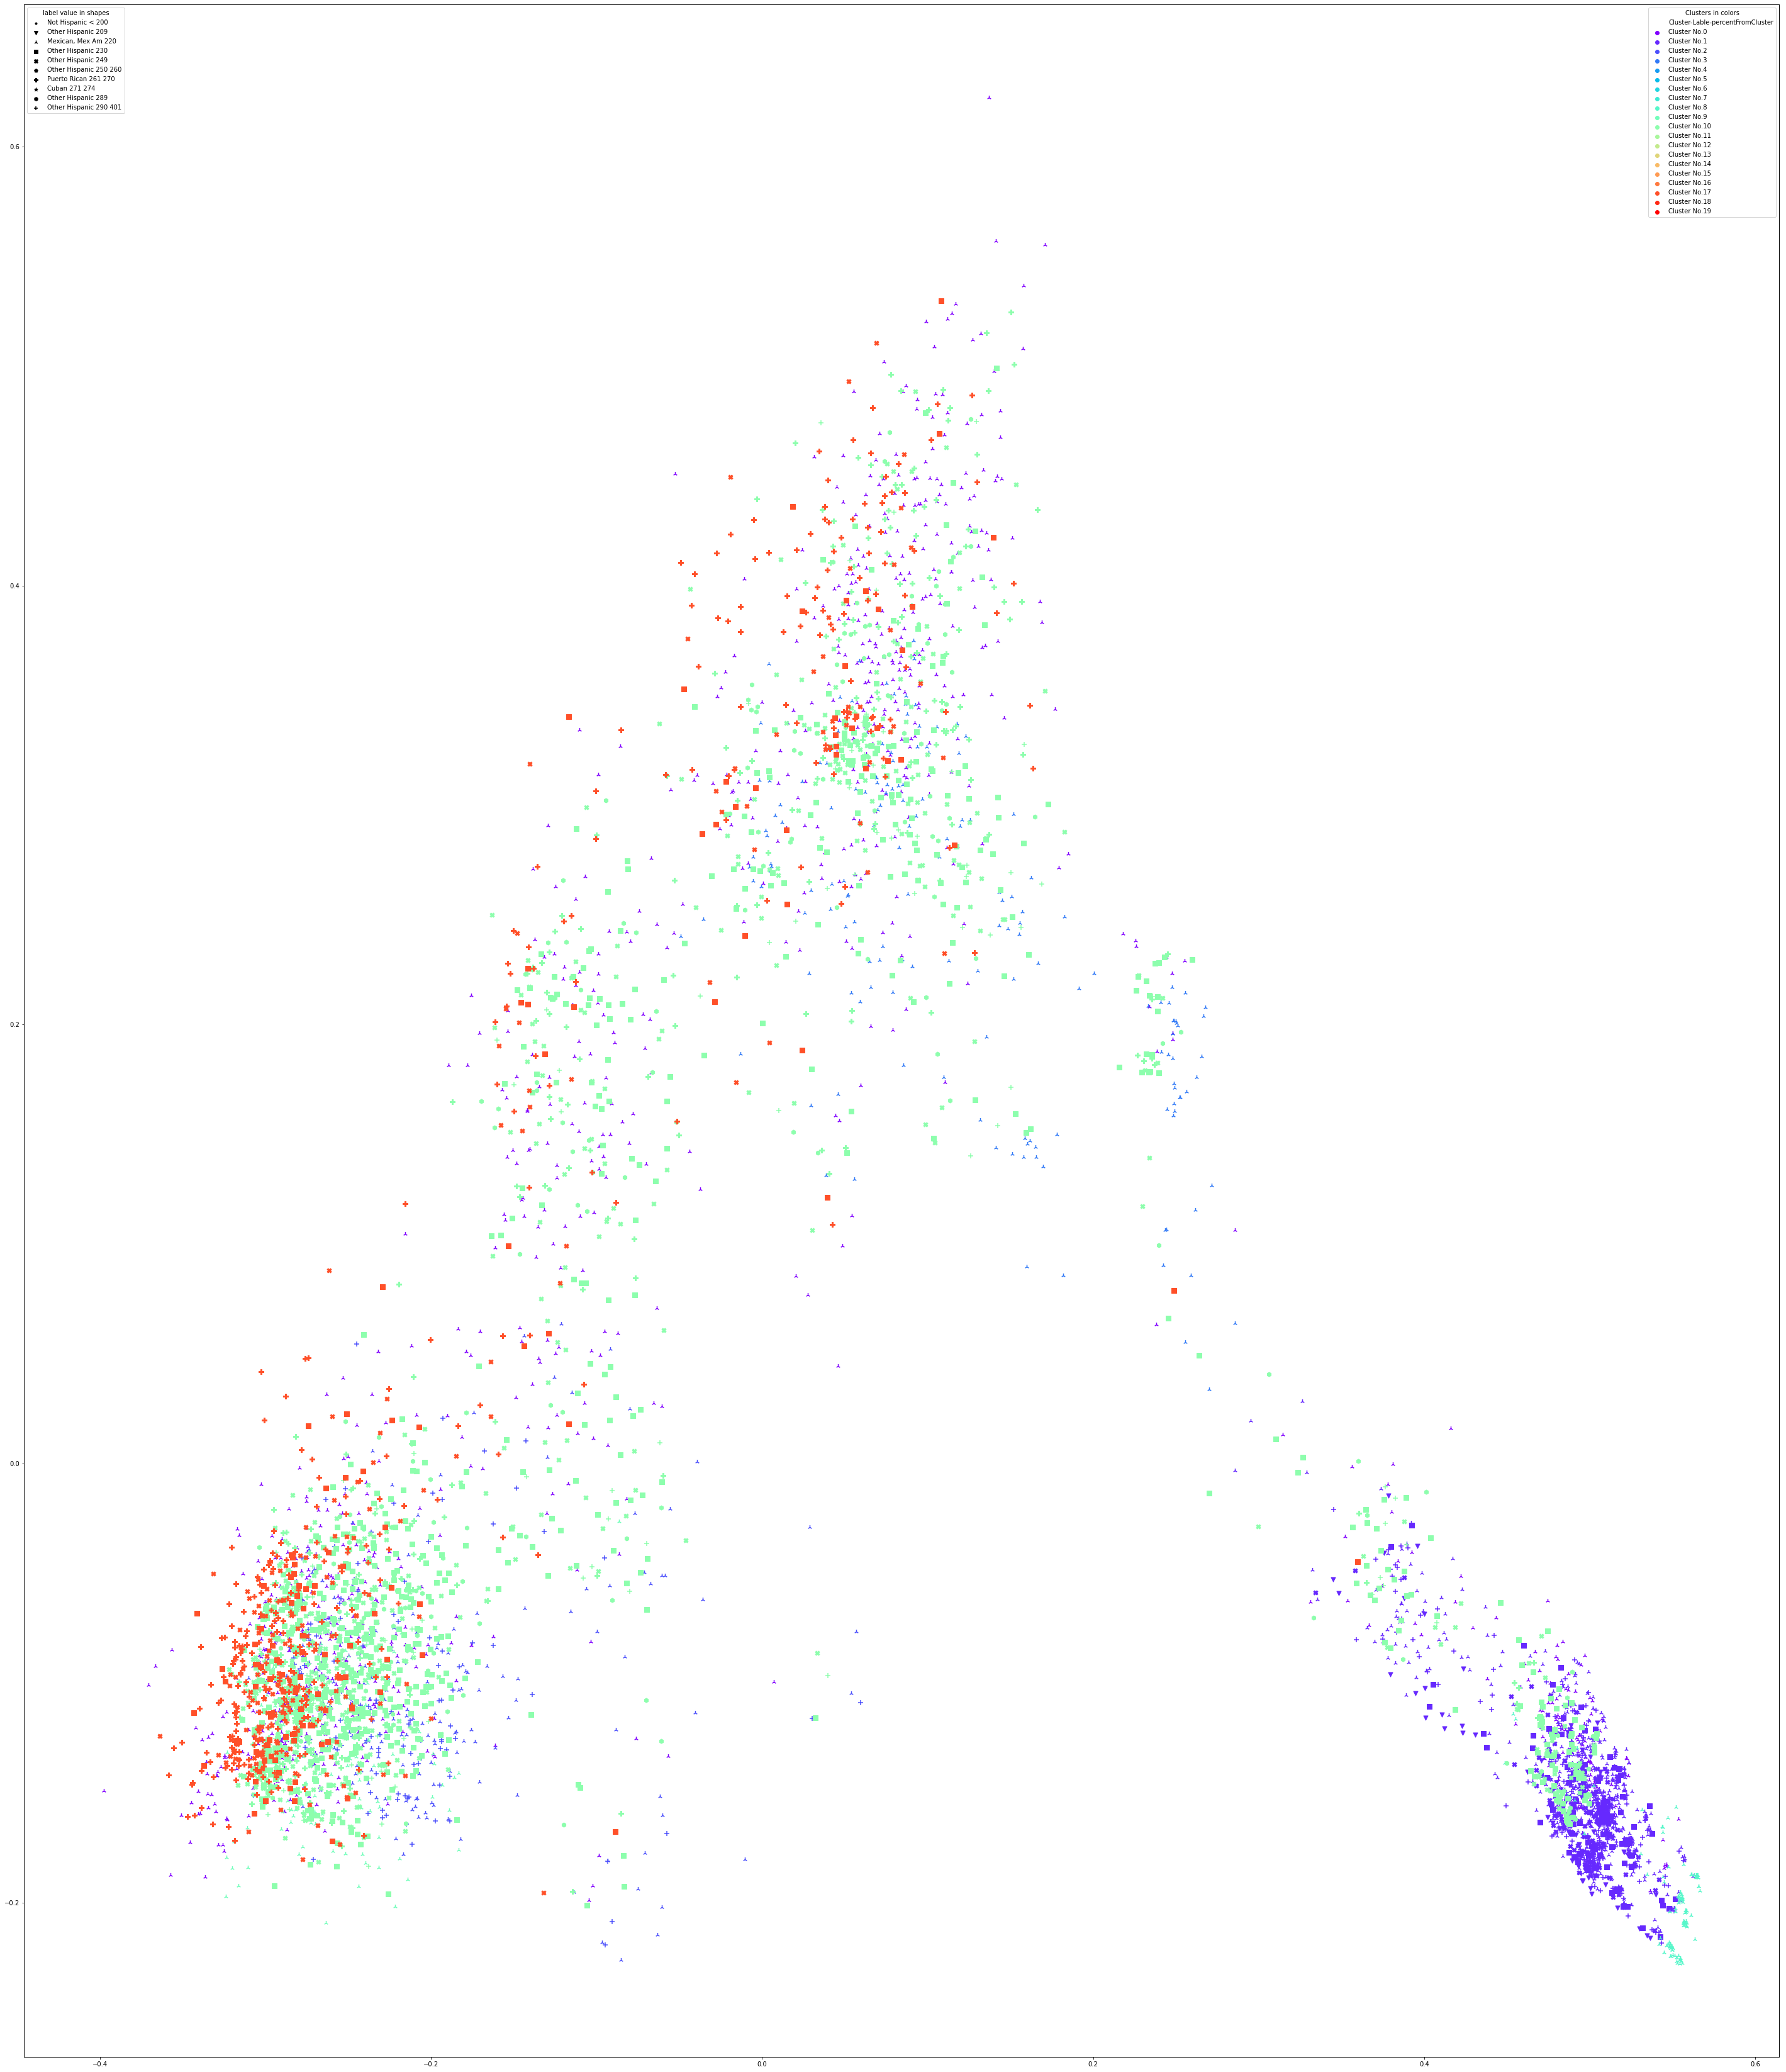

In [ ]:
plot_components(out, 'dHispanic', take_every=1)

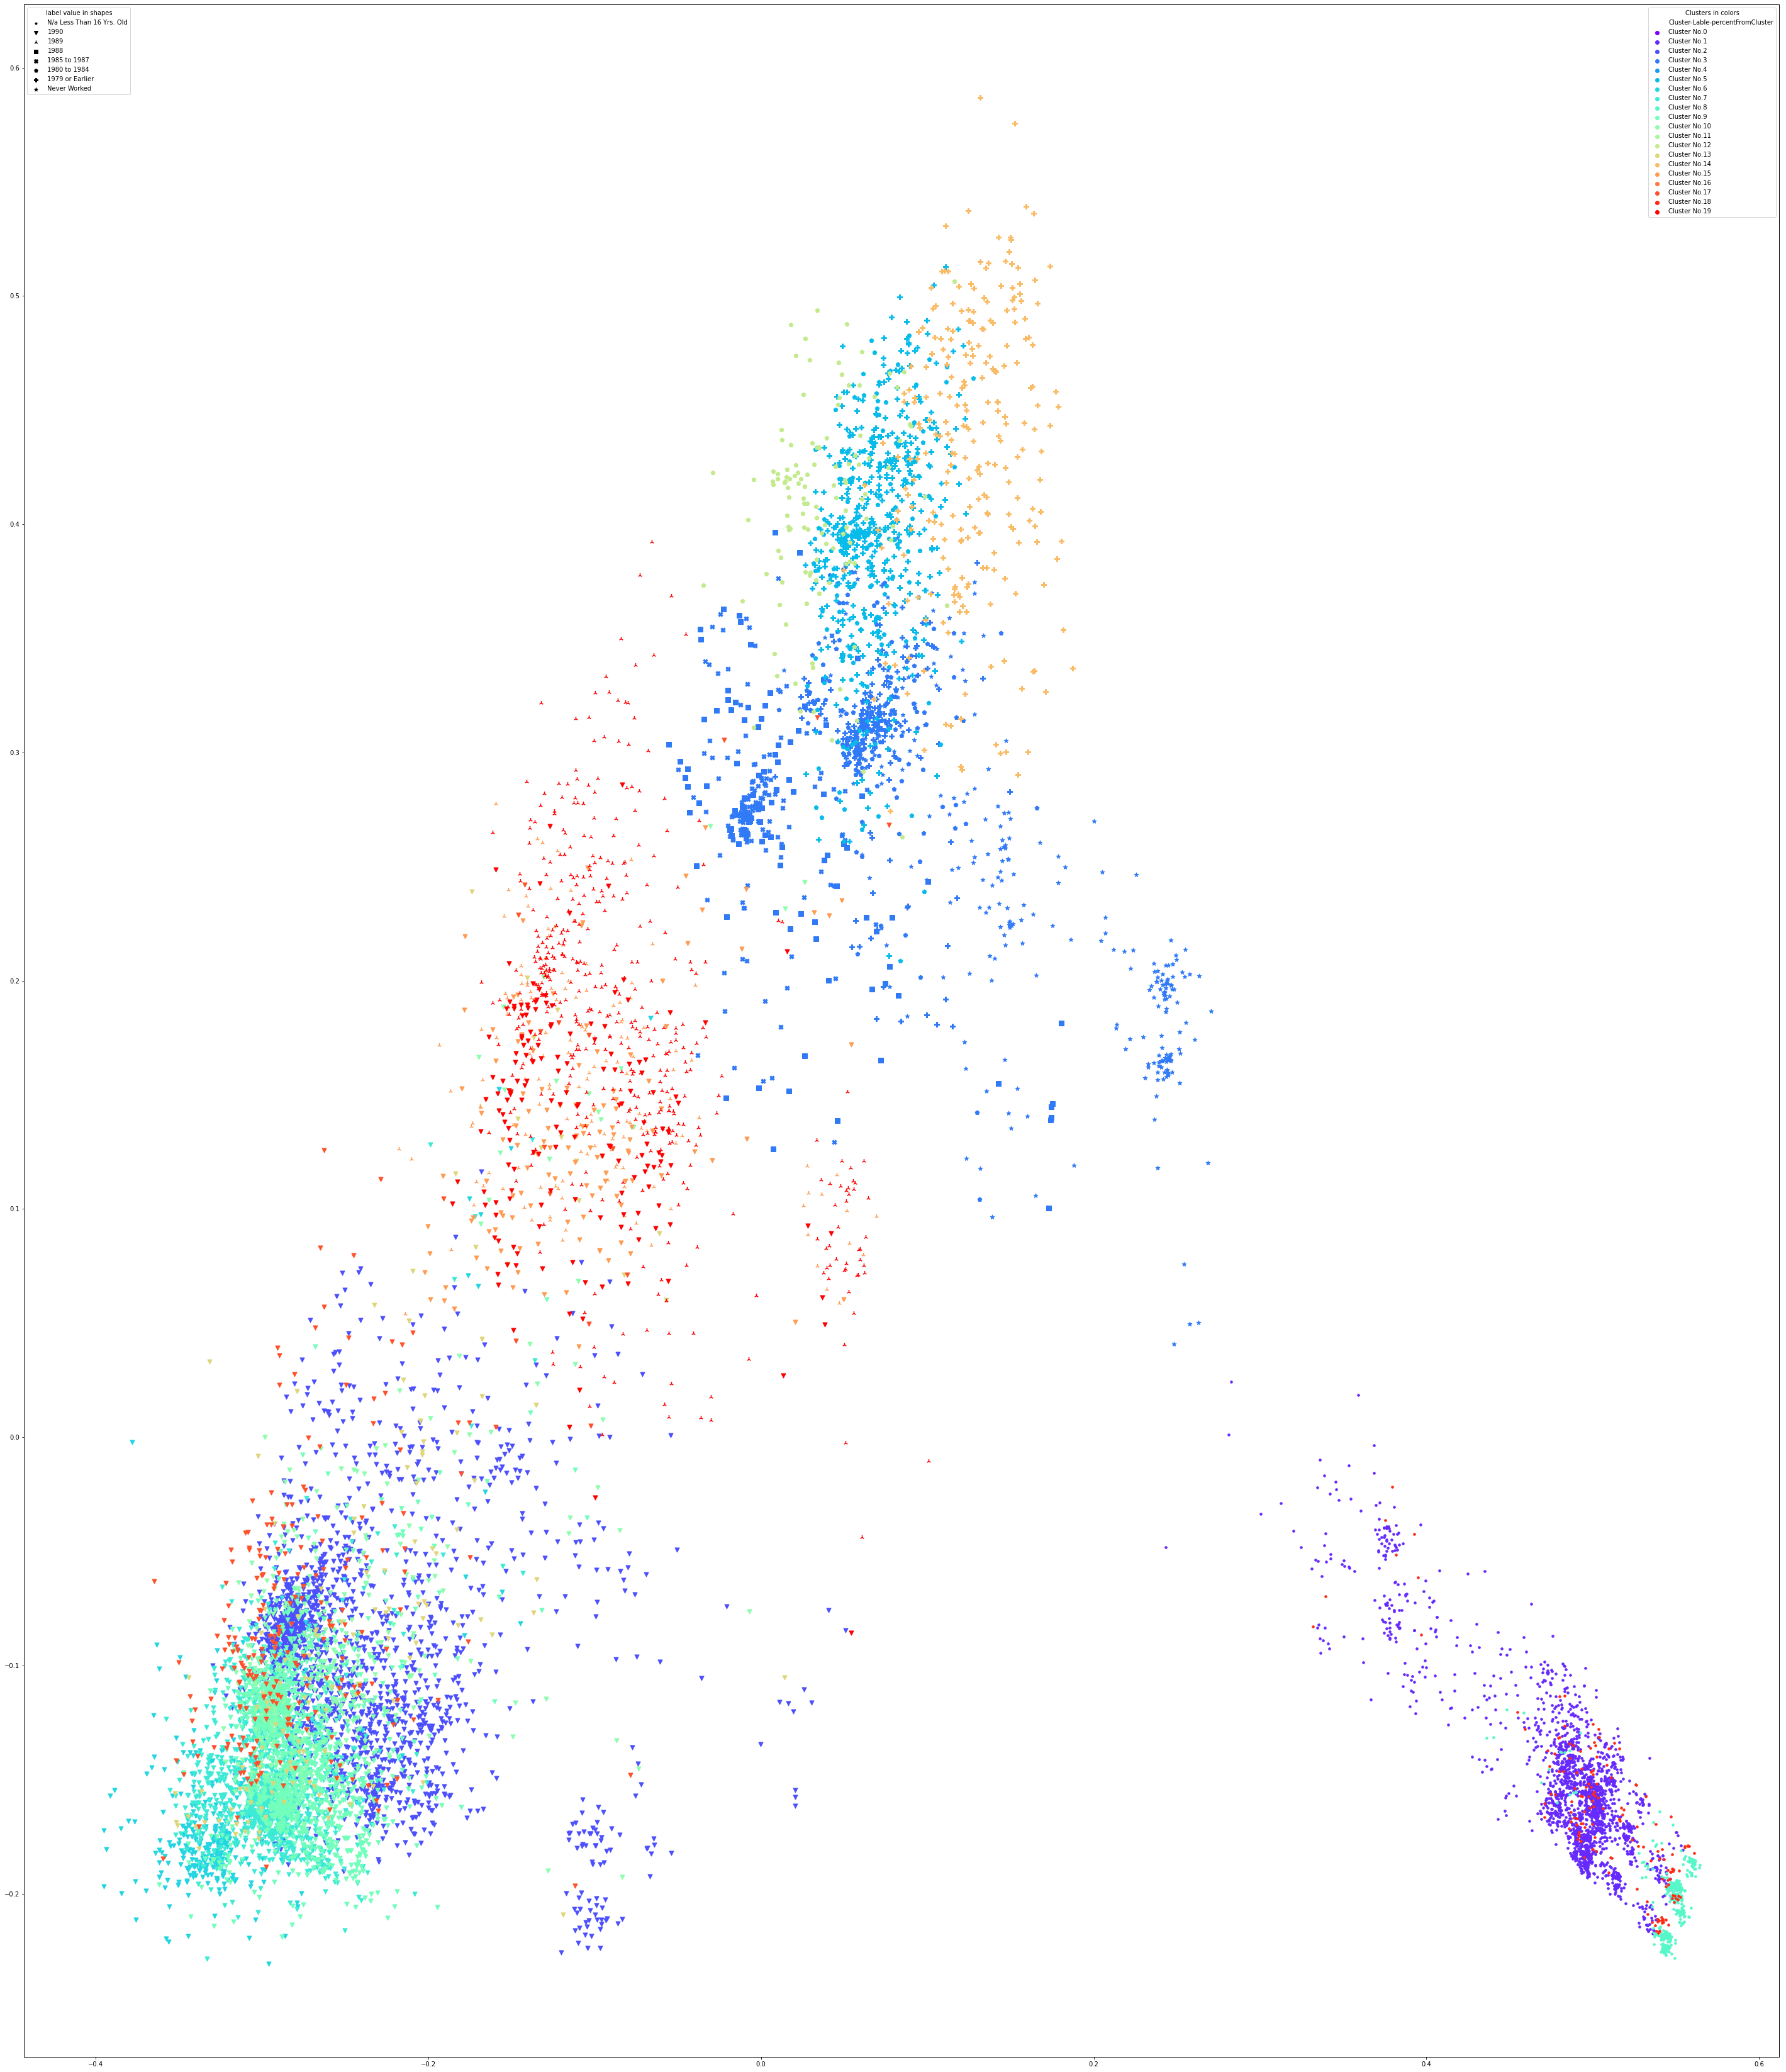

In [ ]:
plot_components(out, 'iYearwrk')

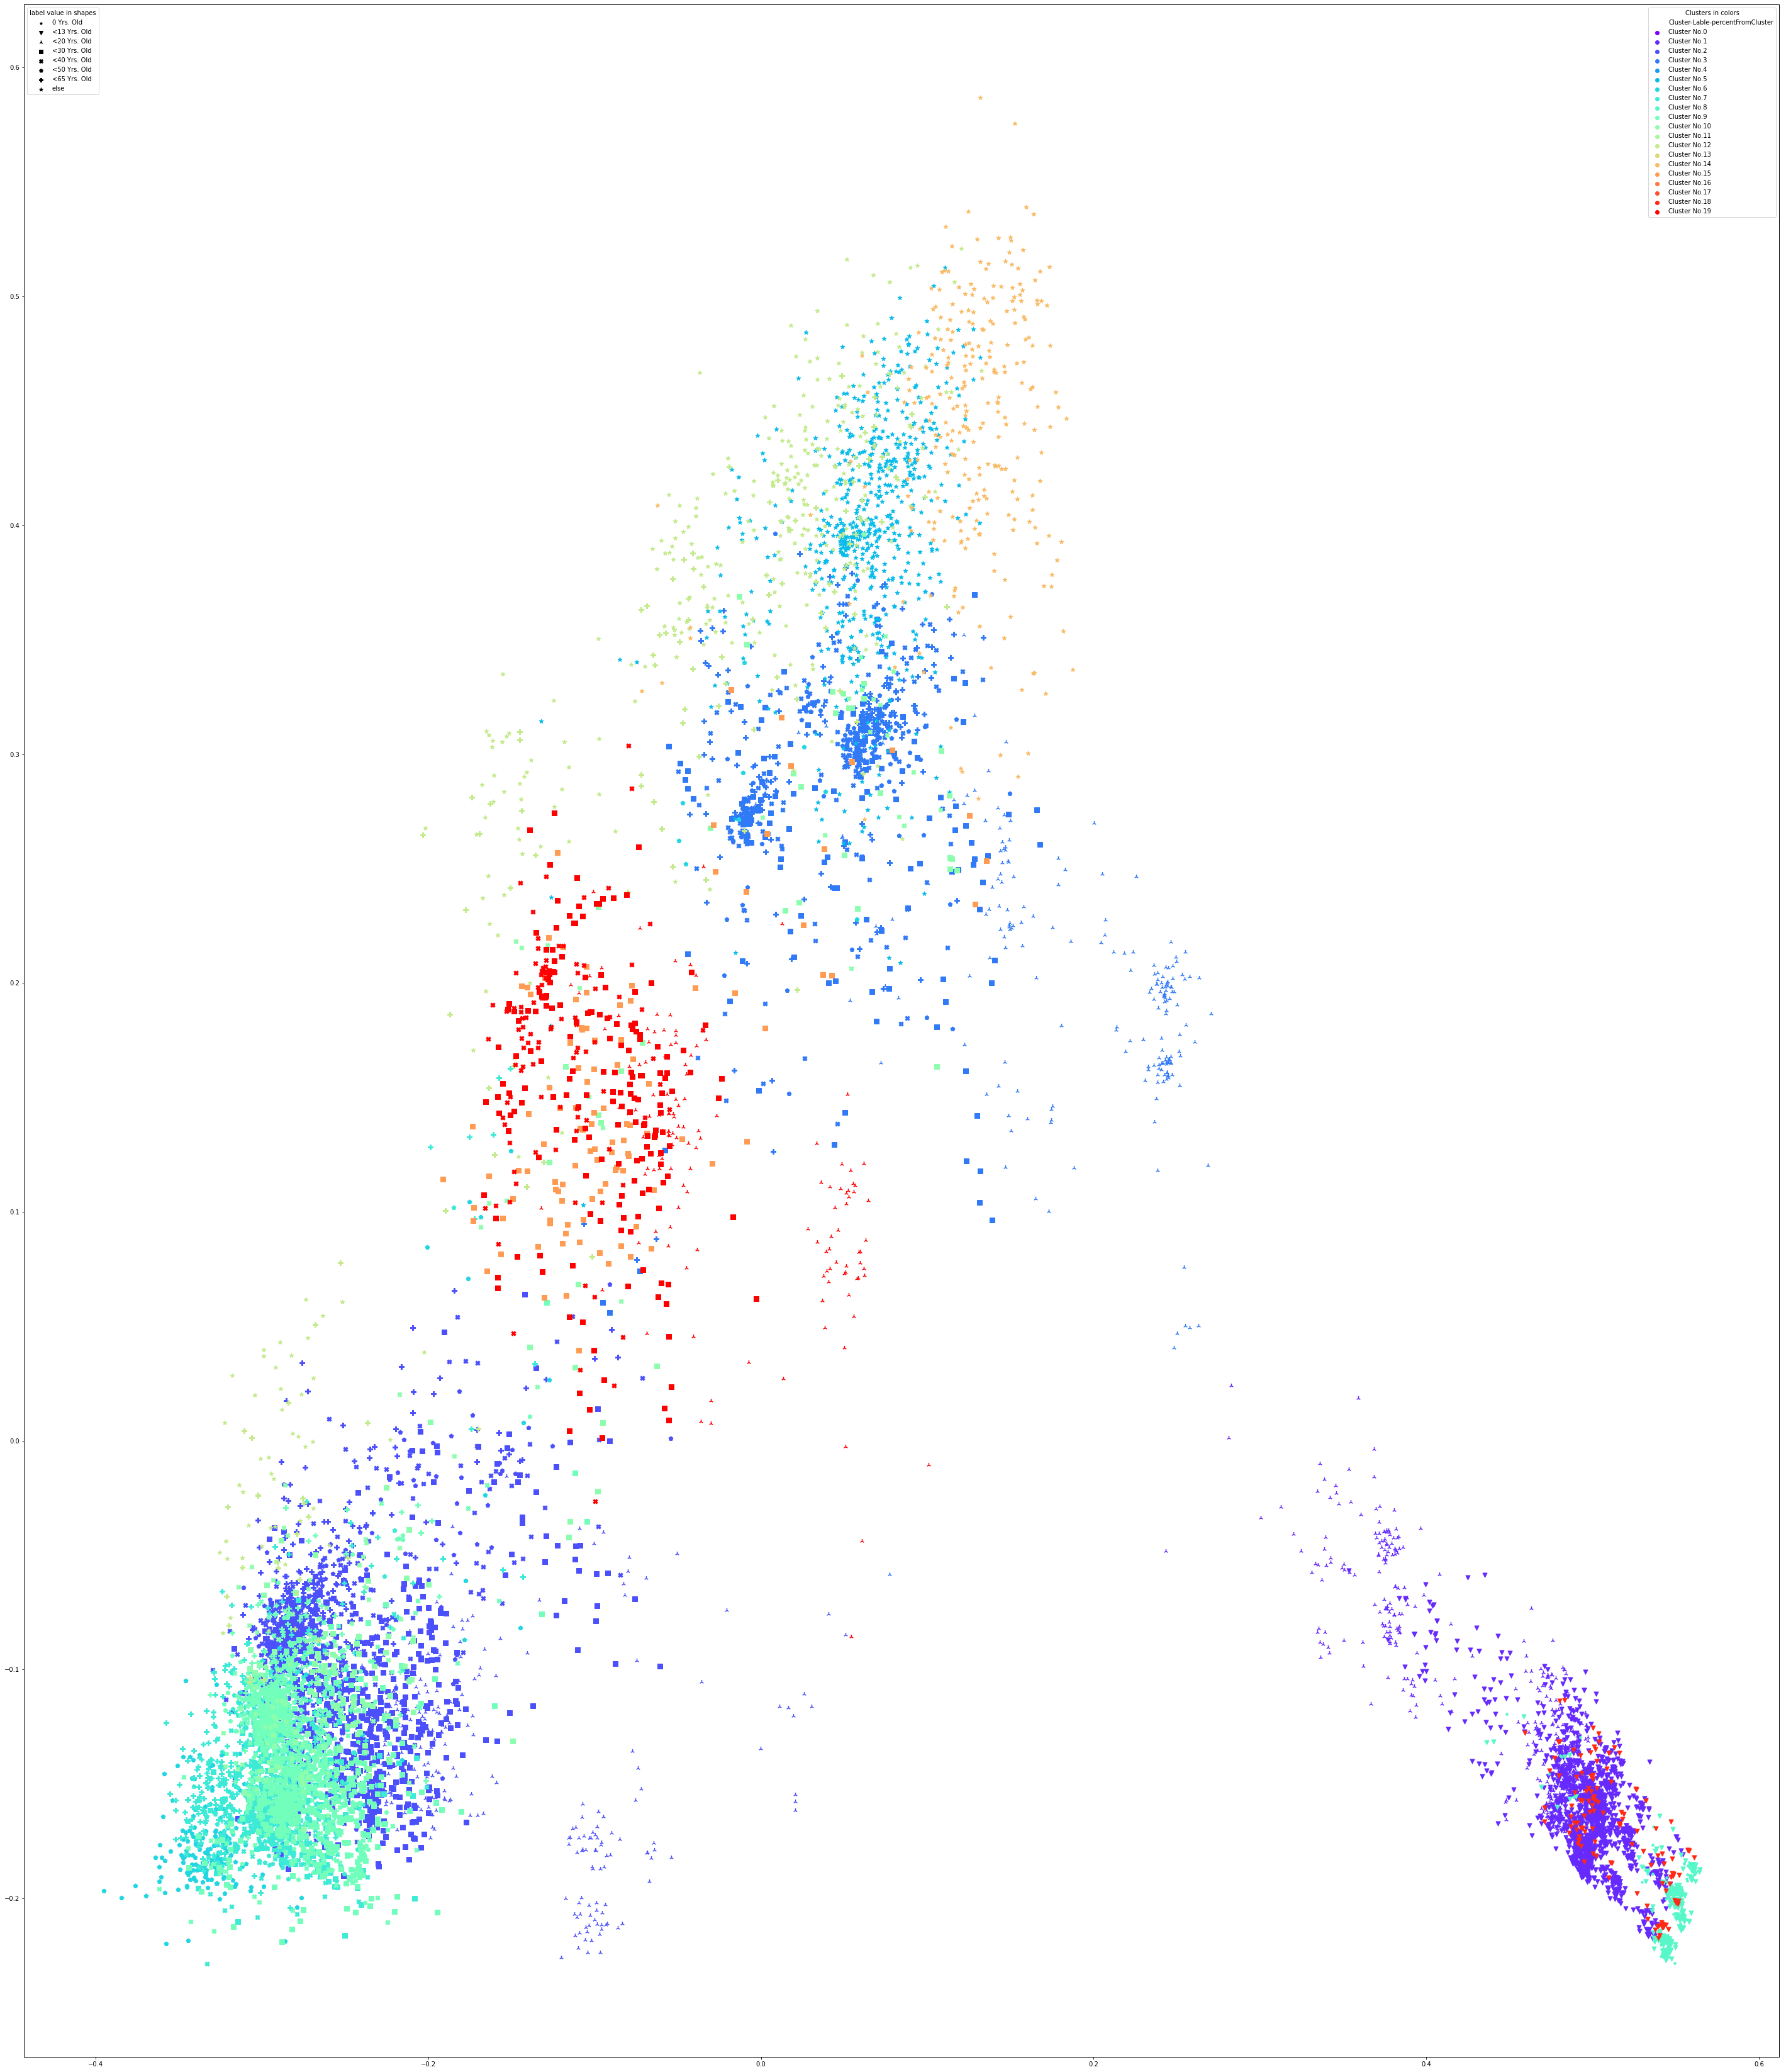

In [ ]:
plot_components(out, 'dAge')

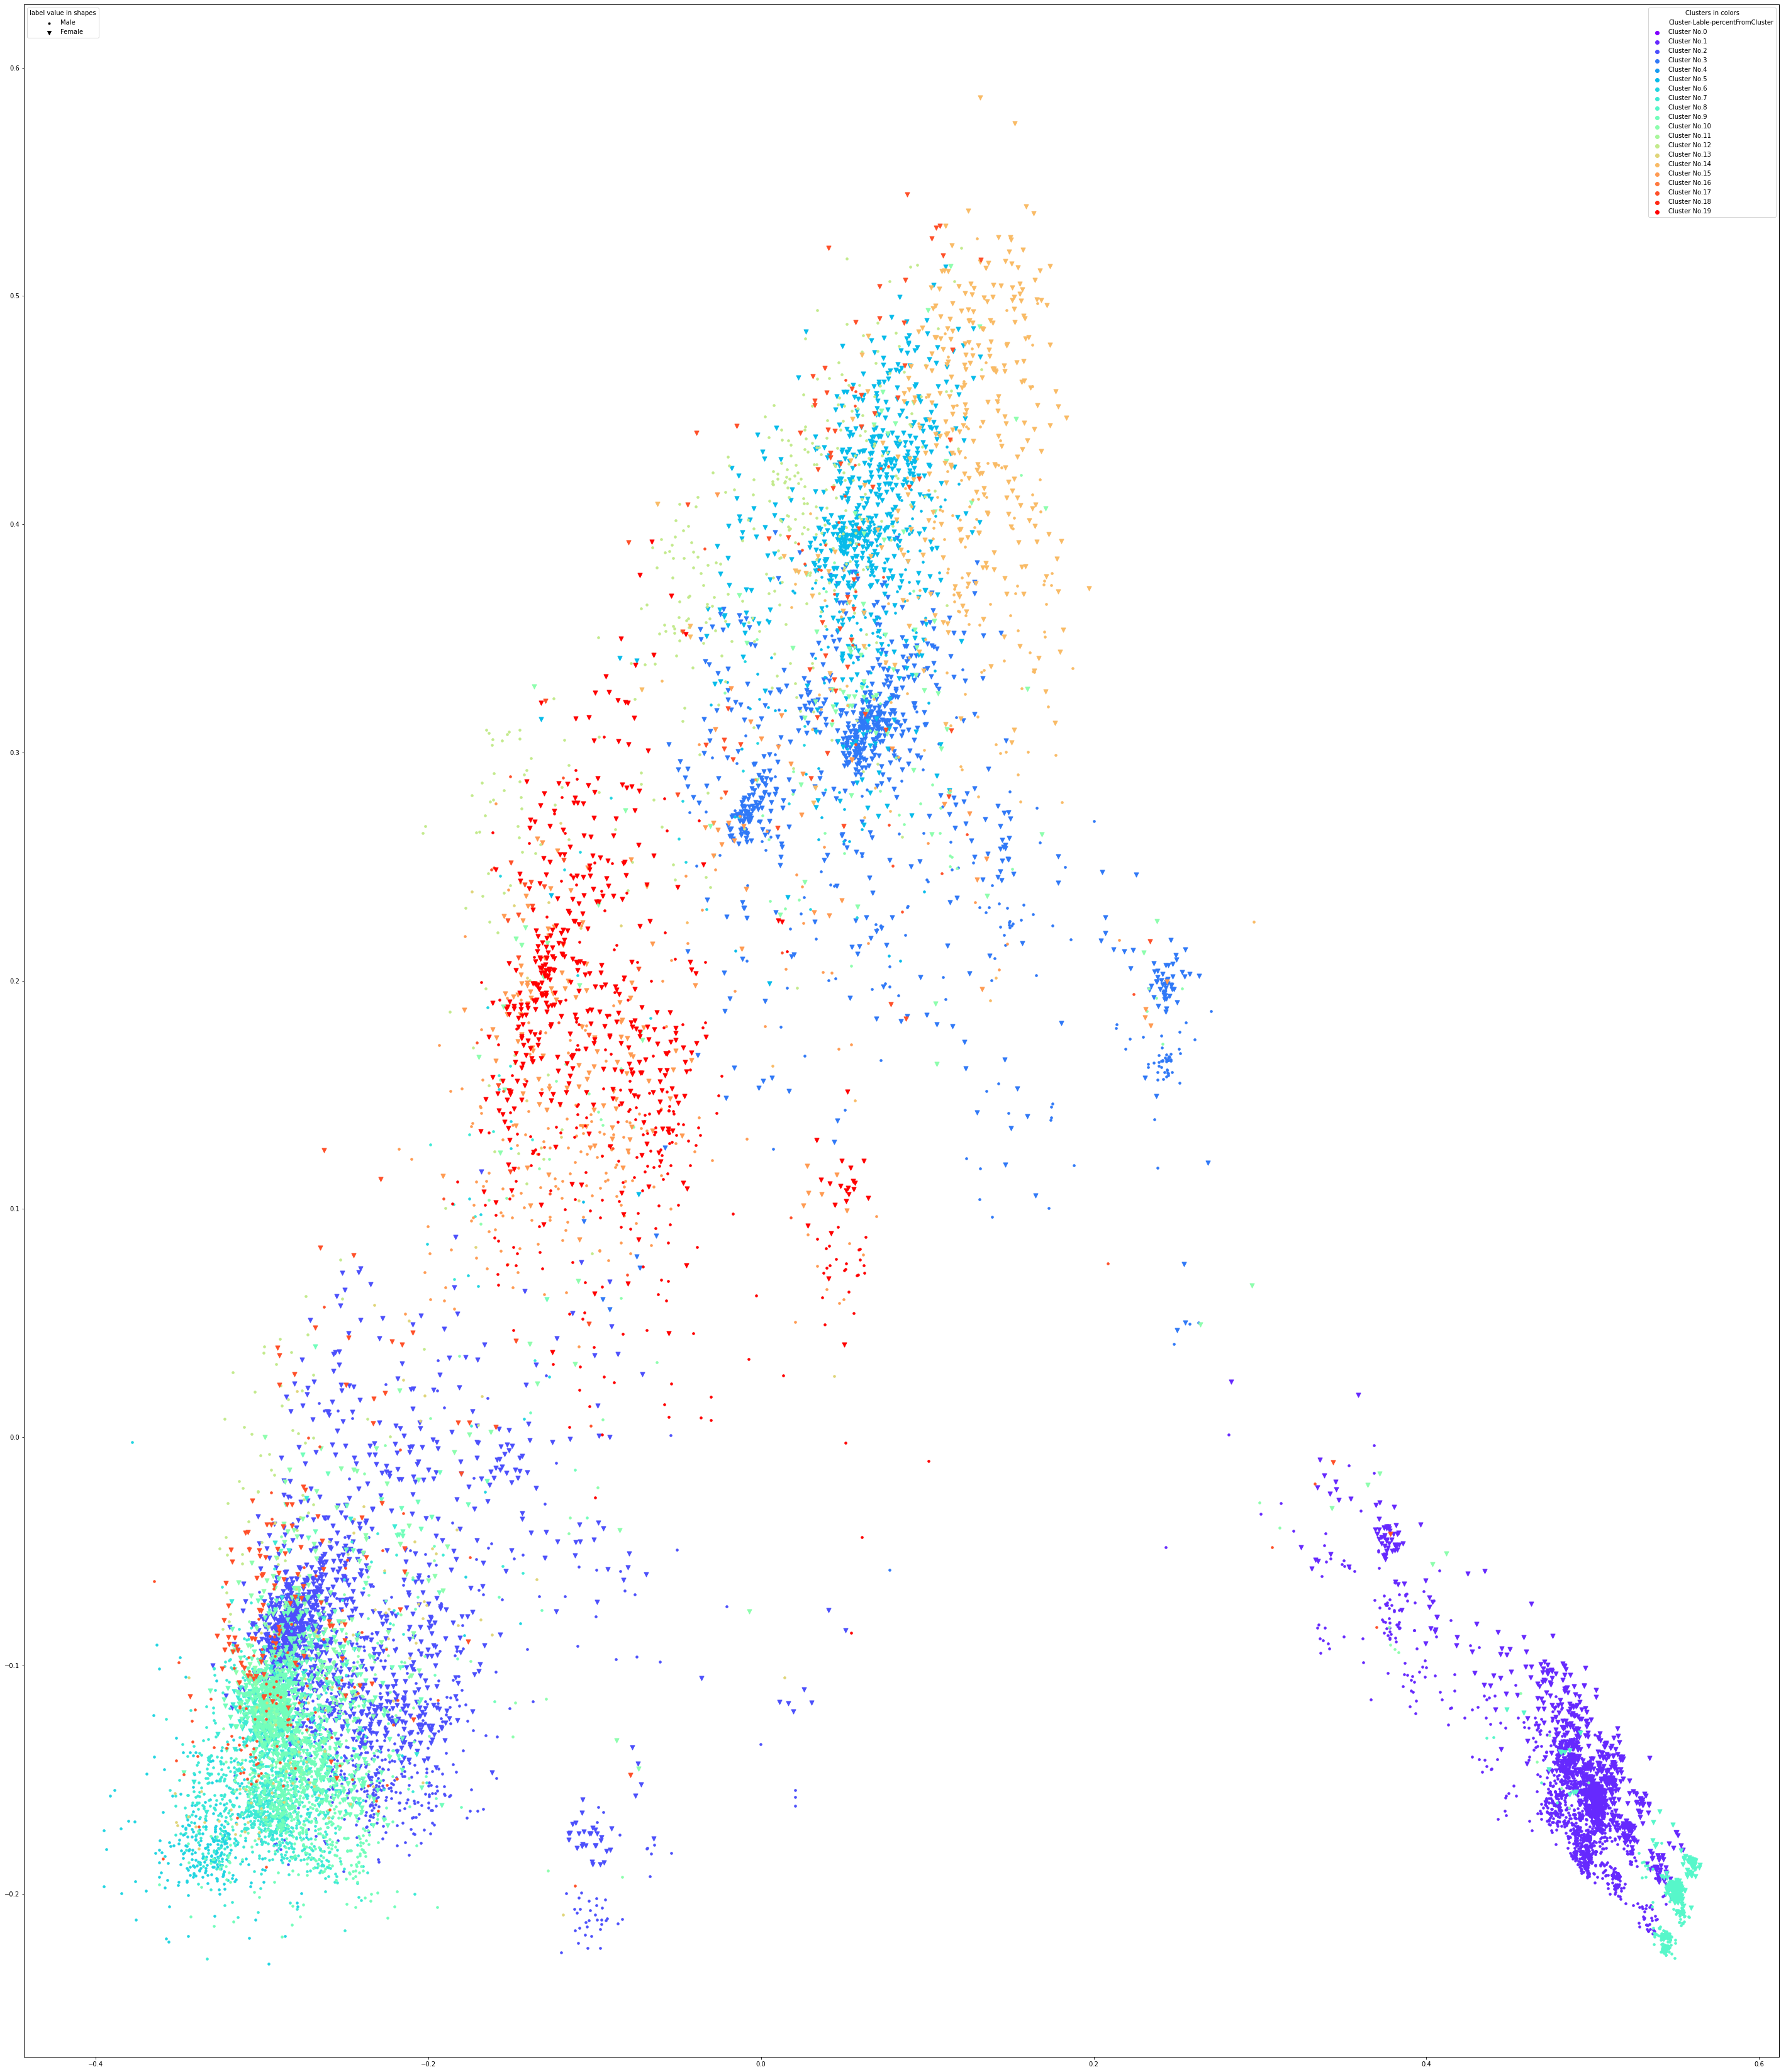

In [ ]:
plot_components(out, 'iSex')